Link to Kaggle Data Set: https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand

# The problem

The purpose of building this model is to predict whether or not a Hotel booking reservation will be canceled within a month of the bookings arrival date. In the Hotel business adequate staffing is not only essential to a good customer experience but it also keeps the business from loosing mone. 

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import pickle
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error


In [2]:
#Load the data
booking_data = pd.read_csv('data/hotel_bookings.csv')

In [3]:
booking_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
#Rows & Columns
booking_data.shape

(119390, 32)

It can be seen that there are 32 columns that contain 12 categorical features and 20 numerical features as follows.

In [5]:
#Summary of the data
booking_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

## Explore & Clean the Data

In [6]:
#Null or missing data
booking_data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

The `company` column seems to be almost completely null values. The `agent` column also has a significant amount of null values. However, the goal here is to find which element or combination of elements are likely to cause hotel booking cancellations. Therefore, these columns are not relevant and can be dropped.

The columns `childeren` & `country` have insignificant amounts of null values and can be replaced.

In [7]:
booking_data['children'].fillna(0, inplace=True)
booking_data['country'].fillna('N/A', inplace=True)
booking_data.drop(['agent','company','arrival_date_week_number'],axis=1,inplace=True)

In [8]:
booking_data.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status          

In [9]:
booking_data.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119390.0,0.103886,0.398555,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0
is_repeated_guest,119390.0,0.031912,0.175767,0.00,0.00,0.000,0.0,1.0


In [10]:
#number of unique Resort Hotel & City Hotel bookings
hotel_type = booking_data['hotel'].value_counts()
hotel_type

City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64

The data contains almost double the amount of City Hotel bookings compared to Resort Hotel bookings



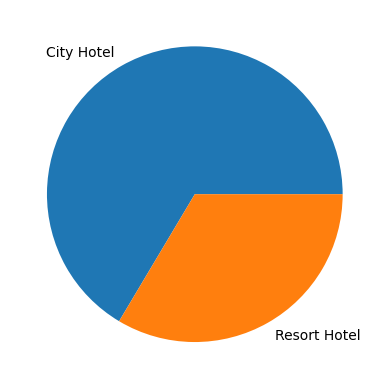

In [11]:
y = hotel_type.tolist()

labels = hotel_type.index.tolist()

plt.pie(y, labels=labels)
plt.show()


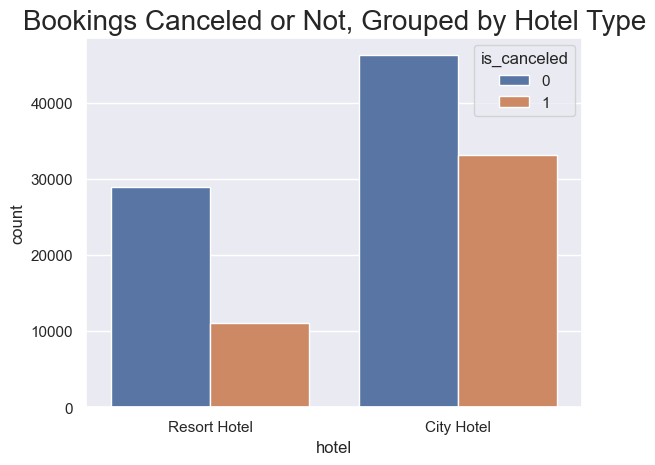

In [12]:
#Between the City and Reort Hotels, how many bookings were Canceled vs Not Canceled 
sns.set(style = "darkgrid")
plt.title("Bookings Canceled or Not, Grouped by Hotel Type", fontdict = {'fontsize': 20})
ax = sns.countplot(x = "hotel", hue = 'is_canceled', data = booking_data)

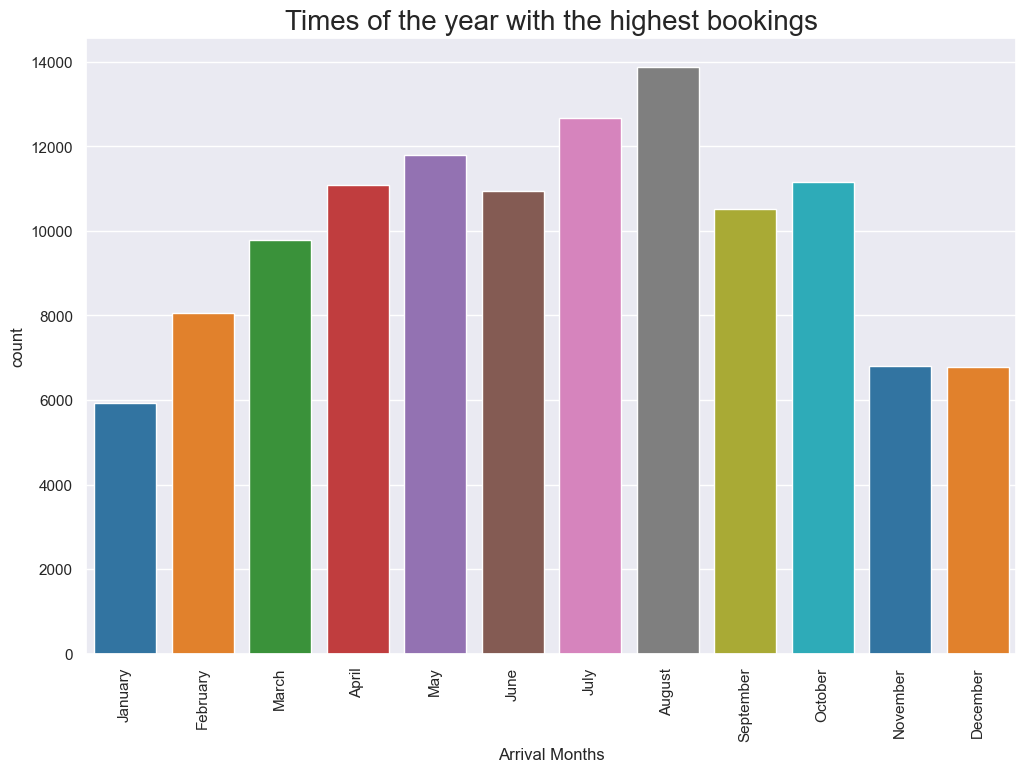

In [13]:
#Sort months in correct order for better visulization
months_sorted = ['January','February','March','April','May','June','July','August','September','October','November','December']

plt.figure(figsize=(12,8))
plt.title("Times of the year with the highest bookings", fontdict = {'fontsize': 20})
sns.countplot(x = booking_data['arrival_date_month'], palette='tab10', order = months_sorted)
plt.xlabel('Arrival Months')
plt.xticks(rotation = 90)
plt.show()

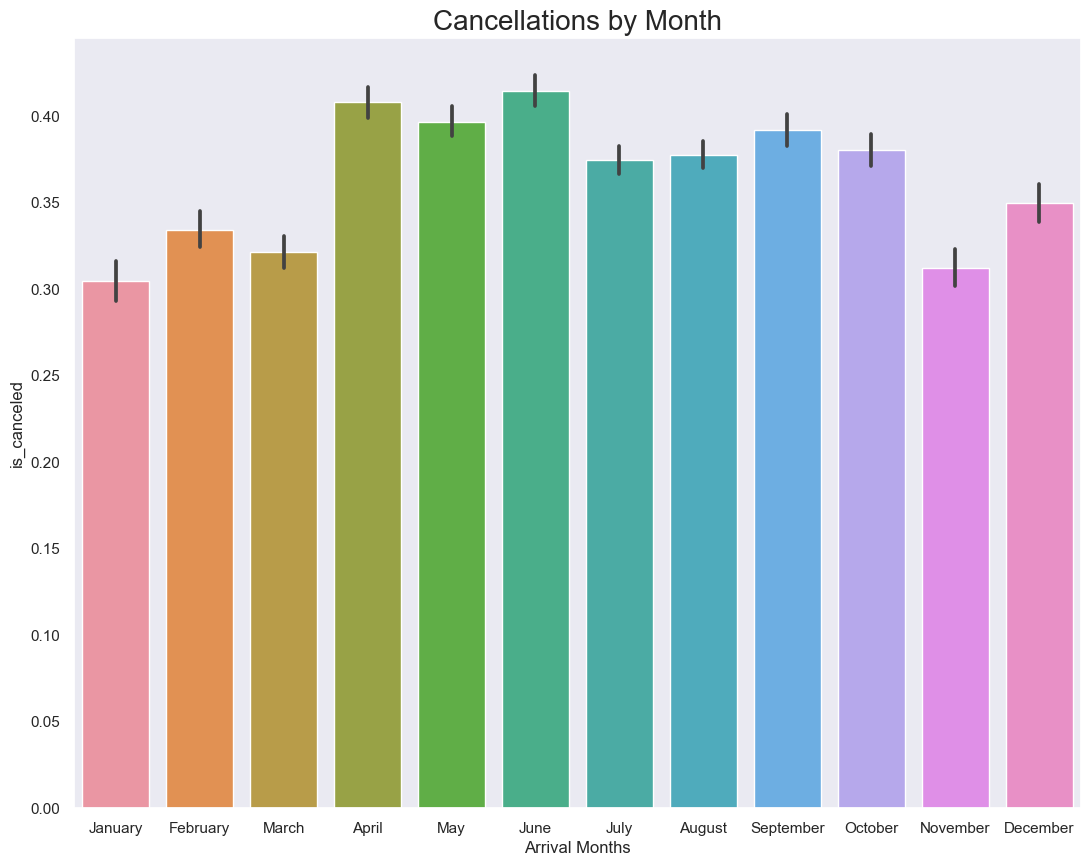

In [14]:
#Time of the year with highes cancellations by month
plt.figure(figsize = (13,10))
sns.set(style="dark")
plt.title("Cancellations by Month", fontdict={'fontsize': 20})
sns.barplot(x = 'arrival_date_month', y = 'is_canceled', data = booking_data, order = months_sorted)
plt.xlabel('Arrival Months')
plt.show()

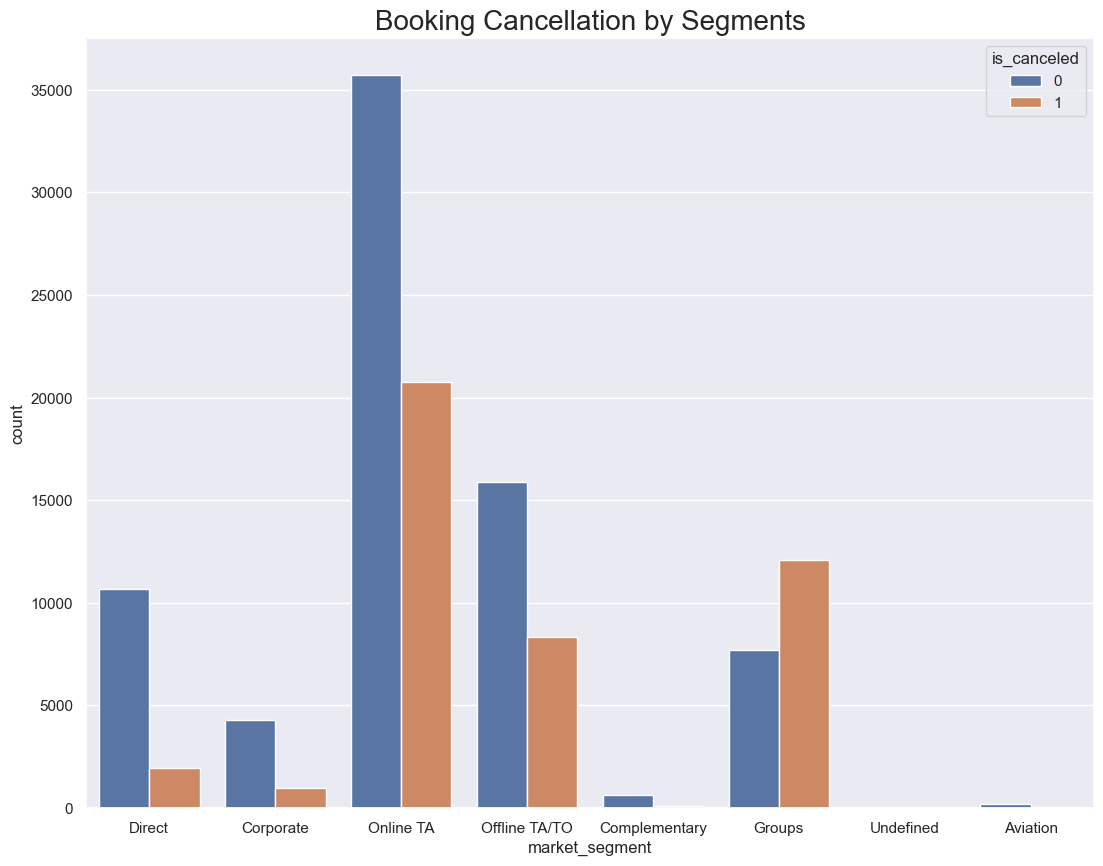

In [15]:
#Bookings that are most likey to cancel based on where reservation was made
plt.figure(figsize = (13,10))
sns.set(style = "darkgrid")
plt.title("Booking Cancellation by Segments", fontdict = {'fontsize':20})
ax = sns.countplot(x = "market_segment", hue = 'is_canceled', data = booking_data)

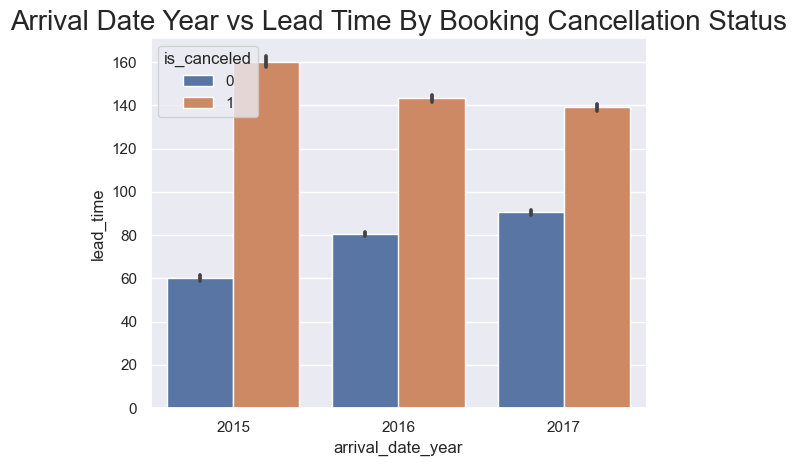

In [16]:
sns.set(style = "darkgrid")
plt.title("Arrival Date Year vs Lead Time By Booking Cancellation Status", fontdict = {'fontsize': 20})
ax = sns.barplot(x = "arrival_date_year", y = "lead_time" ,hue = 'is_canceled', data = booking_data)

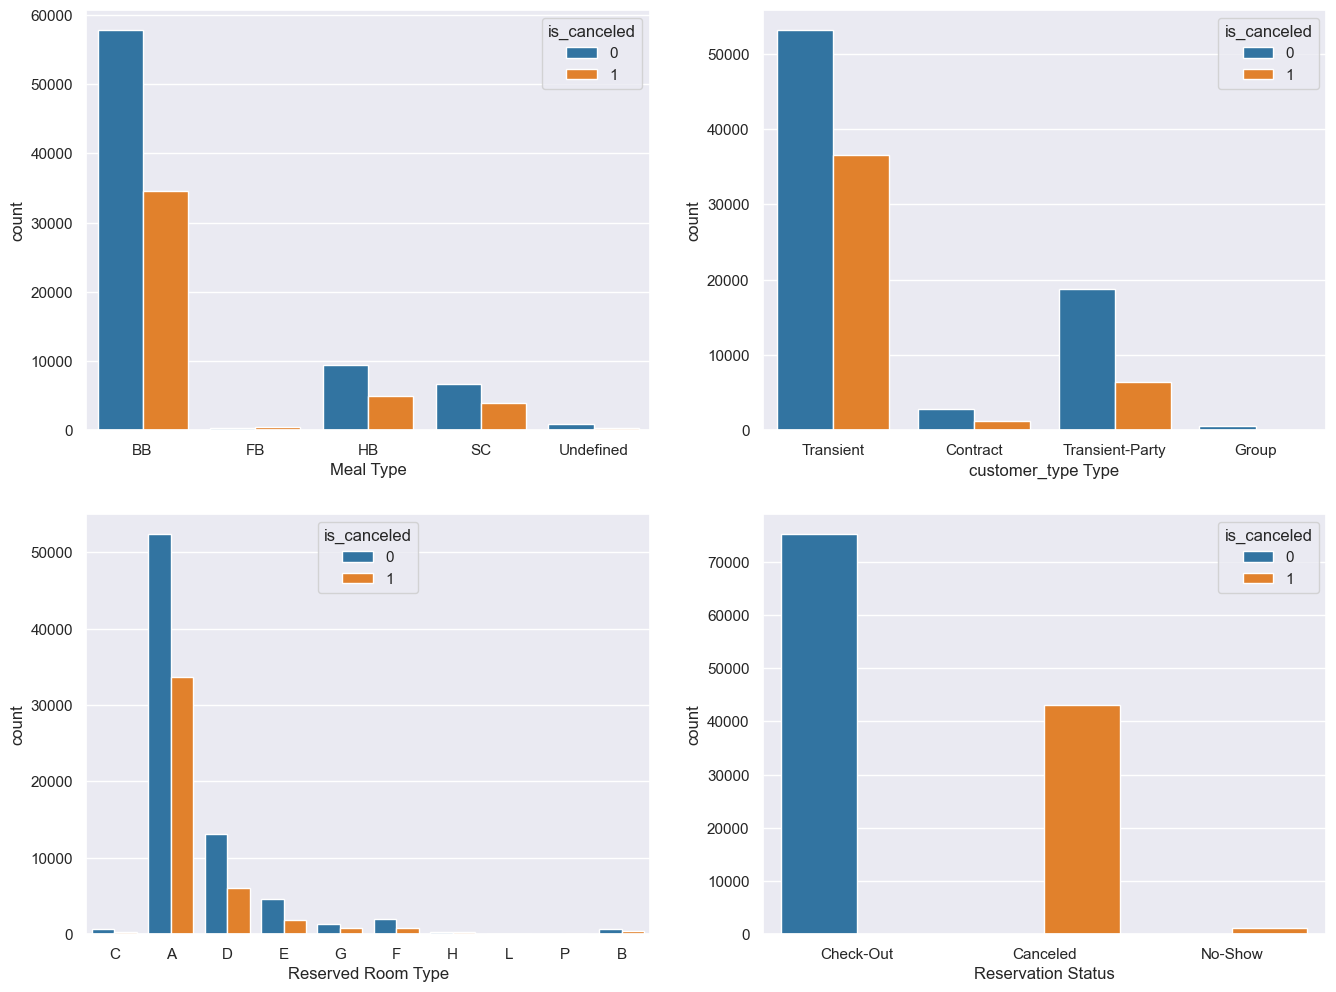

In [17]:
plt.figure(figsize=(16,12))
sns.set(palette = "tab10")
plt.subplot(221)
sns.countplot(x = booking_data['meal'], hue=booking_data['is_canceled'])
plt.xlabel('Meal Type')
plt.subplot(222)
sns.countplot(x = booking_data['customer_type'], hue=booking_data['is_canceled'])
plt.xlabel('customer_type Type')
plt.subplot(223)
sns.countplot(x = booking_data['reserved_room_type'], hue=booking_data['is_canceled'])
plt.xlabel('Reserved Room Type')
plt.subplot(224)
sns.countplot(x = booking_data['reservation_status'], hue=booking_data['is_canceled'])
plt.xlabel('Reservation Status')
plt.show()

There are so many different combinations and discoveries that can be made, but my favorite yet is the following:
As you can see, as a customer has more special requests from the hotel — the less likely they will cancel their trip!

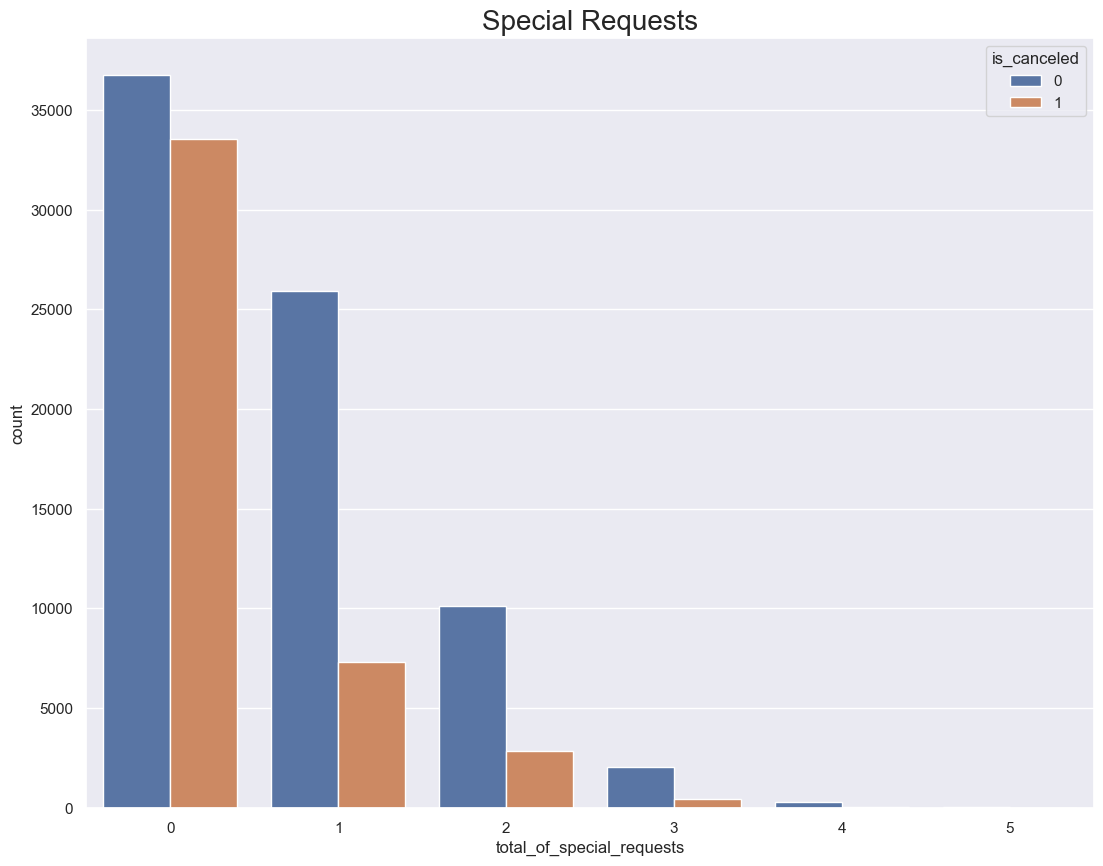

In [18]:
#Bookings made with 1 or more special request are less likey to cancel
plt.figure(figsize = (13,10))
sns.set(style = "darkgrid")
plt.title("Special Requests", fontdict = {'fontsize':20})
ax = sns.countplot(x = "total_of_special_requests", hue = 'is_canceled', data = booking_data)

# Correlation

Columns that have a high influence on the target variable, namely `is_cancelled`. Seeing the result of the statistical correlation test below, we conclude that the numerical features with the highest correlation are `total_of_special_requests` (24%), `required_car_parking_spaces` (19%), `booking_changes` (15%).

In [19]:
correlation = booking_data.corr()['is_canceled'].abs().sort_values(ascending = False)
correlation

is_canceled                       1.000000
lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
arrival_date_year                 0.016660
arrival_date_day_of_month         0.006130
children                          0.005036
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

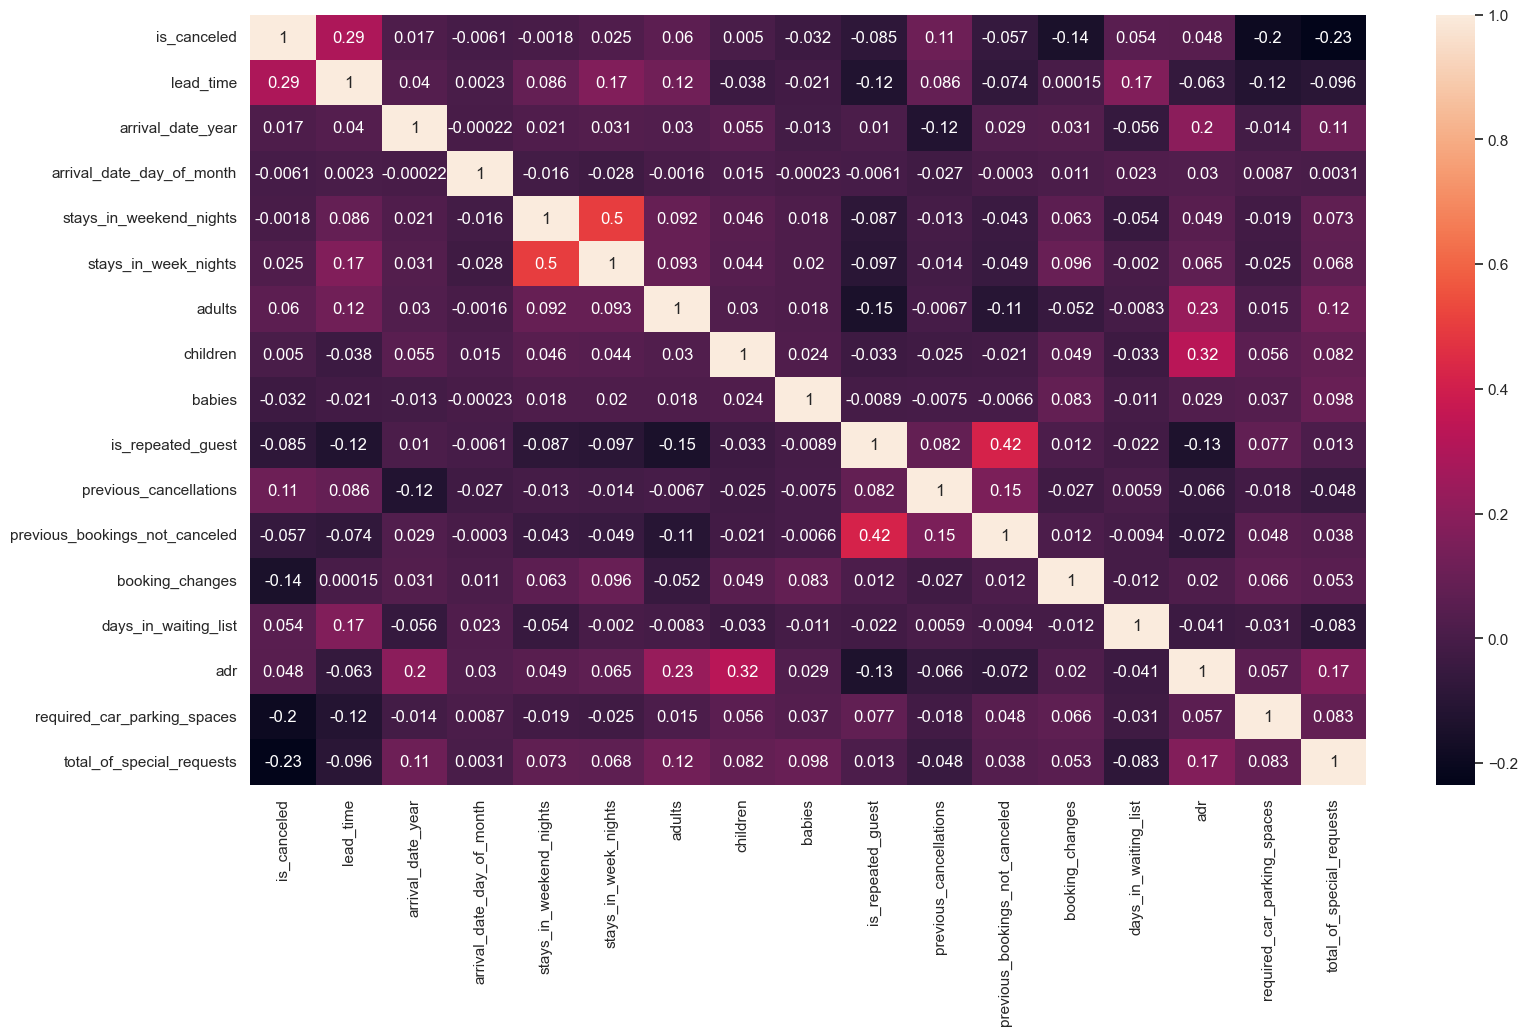

In [20]:
plt.subplots(figsize=(18,10))
sns.heatmap(booking_data.corr(), annot=True);

In [21]:
#Drop columns that are not useful
useless_col = ['days_in_waiting_list', 'arrival_date_year', 'arrival_date_month', 
               'assigned_room_type', 'booking_changes', 'reservation_status', 'country', 'days_in_waiting_list']

In [22]:
booking_data.drop(useless_col, axis = 1, inplace = True)

In [23]:
booking_data.head().T

,0,1,2,3,4
hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel
is_canceled,0,0,0,0,0
lead_time,342,737,7,13,14
arrival_date_day_of_month,1,1,1,1,1
stays_in_weekend_nights,0,0,0,0,0
stays_in_week_nights,0,0,1,1,2
adults,2,2,1,1,2
children,0.0,0.0,0.0,0.0,0.0
babies,0,0,0,0,0
meal,BB,BB,BB,BB,BB


It would be worthwhile to differentiate which columns are categorical and which are numerical. This is useful for determining the type of visualisation that can later be performed.

In [24]:
#columns of dtype 'object'
df_cat = booking_data.select_dtypes(['object'])
df_cat.head()

,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,reservation_status_date
0,Resort Hotel,BB,Direct,Direct,C,No Deposit,Transient,2015-07-01
1,Resort Hotel,BB,Direct,Direct,C,No Deposit,Transient,2015-07-01
2,Resort Hotel,BB,Direct,Direct,A,No Deposit,Transient,2015-07-02
3,Resort Hotel,BB,Corporate,Corporate,A,No Deposit,Transient,2015-07-02
4,Resort Hotel,BB,Online TA,TA/TO,A,No Deposit,Transient,2015-07-03


In [25]:
df_cat['reservation_status_date'] = pd.to_datetime(df_cat.reservation_status_date, format='%Y-%m-%d')
df_cat['year'] = df_cat['reservation_status_date'].dt.year
df_cat['month'] = df_cat['reservation_status_date'].dt.month
df_cat['day'] = df_cat['reservation_status_date'].dt.day
df_cat.drop(['reservation_status_date'] , axis = 1, inplace = True)

In [26]:
df_cat.head()

,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,year,month,day
0,Resort Hotel,BB,Direct,Direct,C,No Deposit,Transient,2015,7,1
1,Resort Hotel,BB,Direct,Direct,C,No Deposit,Transient,2015,7,1
2,Resort Hotel,BB,Direct,Direct,A,No Deposit,Transient,2015,7,2
3,Resort Hotel,BB,Corporate,Corporate,A,No Deposit,Transient,2015,7,2
4,Resort Hotel,BB,Online TA,TA/TO,A,No Deposit,Transient,2015,7,3


## Pre - Processing & Training

In [27]:
#one hot encoding categorical features

df_cat['hotel'] = df_cat['hotel'].map({'Resort Hotel' : 0, 'City Hotel' : 1})

df_cat['meal'] = df_cat['meal'].map({'BB' : 0, 'FB': 1, 'HB': 2, 'SC': 3, 'Undefined': 4})

df_cat['market_segment'] = df_cat['market_segment'].map({'Direct': 0, 'Corporate': 1, 'Online TA': 2, 'Offline TA/TO': 3,
                                                           'Complementary': 4, 'Groups': 5, 'Undefined': 6, 'Aviation': 7})

df_cat['distribution_channel'] = df_cat['distribution_channel'].map({'Direct': 0, 'Corporate': 1, 'TA/TO': 2, 'Undefined': 3,
                                                                       'GDS': 4})

df_cat['reserved_room_type'] = df_cat['reserved_room_type'].map({'C': 0, 'A': 1, 'D': 2, 'E': 3, 'G': 4, 'F': 5, 'H': 6,
                                                                   'L': 7, 'P': 8, 'B': 9})

df_cat['deposit_type'] = df_cat['deposit_type'].map({'No Deposit': 0, 'Refundable': 1, 'Non Refund': 3})

df_cat['customer_type'] = df_cat['customer_type'].map({'Transient': 0, 'Contract': 1, 'Transient-Party': 2, 'Group': 3})


In [28]:
df_cat.head()

,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,year,month,day
0,0,0,0,0,0,0,0,2015,7,1
1,0,0,0,0,0,0,0,2015,7,1
2,0,0,0,0,1,0,0,2015,7,2
3,0,0,1,1,1,0,0,2015,7,2
4,0,0,2,2,1,0,0,2015,7,3


In [29]:
#columns of numerical dtypes

df_num = booking_data.select_dtypes(['int64', 'float'])

df_num.drop('is_canceled', axis = 1, inplace = True)

In [30]:
df_num.head().T

,0,1,2,3,4
lead_time,342.0,737.0,7.0,13.0,14.0
arrival_date_day_of_month,1.0,1.0,1.0,1.0,1.0
stays_in_weekend_nights,0.0,0.0,0.0,0.0,0.0
stays_in_week_nights,0.0,0.0,1.0,1.0,2.0
adults,2.0,2.0,1.0,1.0,2.0
children,0.0,0.0,0.0,0.0,0.0
babies,0.0,0.0,0.0,0.0,0.0
is_repeated_guest,0.0,0.0,0.0,0.0,0.0
previous_cancellations,0.0,0.0,0.0,0.0,0.0
previous_bookings_not_canceled,0.0,0.0,0.0,0.0,0.0


In [31]:
df_num.var()

lead_time                         11419.721511
arrival_date_day_of_month            77.102966
stays_in_weekend_nights               0.997229
stays_in_week_nights                  3.641554
adults                                0.335543
children                              0.158846
babies                                0.009494
is_repeated_guest                     0.030894
previous_cancellations                0.712904
previous_bookings_not_canceled        2.242317
adr                                2553.866100
required_car_parking_spaces           0.060168
total_of_special_requests             0.628529
dtype: float64

## Train/Test Split

In [32]:
X = pd.concat([df_cat, df_num], axis = 1)

y = booking_data['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 432)

In [33]:
X_train.shape, X_test.shape

((83573, 23), (35817, 23))

In [34]:
y_train.shape, y_test.shape

((83573,), (35817,))

In [35]:
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

hotel                               int64
meal                                int64
market_segment                      int64
distribution_channel                int64
reserved_room_type                  int64
deposit_type                        int64
customer_type                       int64
year                                int64
month                               int64
day                                 int64
lead_time                           int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
adr                               float64
required_car_parking_spaces         int64
total_of_special_requests           int64
dtype: object

In [36]:
#Repeat this check for the test split in `X_test`
X_test.dtypes

hotel                               int64
meal                                int64
market_segment                      int64
distribution_channel                int64
reserved_room_type                  int64
deposit_type                        int64
customer_type                       int64
year                                int64
month                               int64
day                                 int64
lead_time                           int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
adr                               float64
required_car_parking_spaces         int64
total_of_special_requests           int64
dtype: object

## Standard Scaler

In [37]:
#Scale on the training data

scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

## Model Selection

## Logistic Regression

##### Train model on the train split

In [38]:
lr = LogisticRegression()
lr.fit(X_tr_scaled, y_train)

y_pred_lr = lr.predict(X_te_scaled)

acc_lr = accuracy_score(y_test, y_pred_lr)
lr_conf = confusion_matrix(y_test, y_pred_lr)
lr_clf_report = classification_report(y_test, y_pred_lr)
lr_scores = cross_val_score(lr, X_tr_scaled, y_train, cv=5)

print(f"Accuracy Score of Logistic Regression is : {acc_lr}")
print("Average cross validation score: {:.3f}".format(lr_scores.mean()))
print(f"Confusion Matrix : n{lr_conf}")
print(f"Classification Report : n{lr_clf_report}")

Accuracy Score of Logistic Regression is : 0.8102576988580842
Average cross validation score: 0.809
Confusion Matrix : n[[21566   989]
 [ 5807  7455]]
Classification Report : n              precision    recall  f1-score   support

           0       0.79      0.96      0.86     22555
           1       0.88      0.56      0.69     13262

    accuracy                           0.81     35817
   macro avg       0.84      0.76      0.78     35817
weighted avg       0.82      0.81      0.80     35817



With this Logistic Regression model booking cancellations can be predicted with an accuracy of only `81%`. I have faith that a model with much better accuracy can still be created!

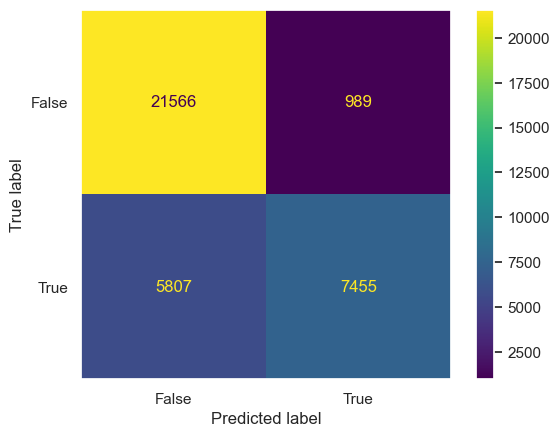

In [39]:
#Plot Logistic Regression Confusion Matrix
lr_conf_display = ConfusionMatrixDisplay(confusion_matrix = lr_conf, display_labels = [False, True])
lr_conf_display.plot()
plt.grid(False)
plt.show()

## Random Forest Classifier

In [40]:
rfc = RandomForestClassifier()
rfc.fit(X_tr_scaled, y_train)

y_pred_rfc = rfc.predict(X_te_scaled)

acc_rfc = accuracy_score(y_test, y_pred_rfc)
rfc_conf = confusion_matrix(y_test, y_pred_rfc)
rfc_clf_report = classification_report(y_test, y_pred_rfc)
rfc_scores = cross_val_score(rfc, X_tr_scaled, y_train, cv=5)

print(f"Accuracy Score of Random Forest is : {acc_rfc}")
print("Average cross validation score: {:.3f}".format(rfc_scores.mean()))
print(f"Confusion Matrix : n{rfc_conf}")
print(f"Classification Report : n{rfc_clf_report}")

Accuracy Score of Random Forest is : 0.9299773850406232
Average cross validation score: 0.926
Confusion Matrix : n[[22062   493]
 [ 2015 11247]]
Classification Report : n              precision    recall  f1-score   support

           0       0.92      0.98      0.95     22555
           1       0.96      0.85      0.90     13262

    accuracy                           0.93     35817
   macro avg       0.94      0.91      0.92     35817
weighted avg       0.93      0.93      0.93     35817



With this Random Forest Model we can now predict whether or not a new booking will be canceled with `93% accuarcy`. This will no doubt be very useful in planning things such as room availablity and hotel staffing.

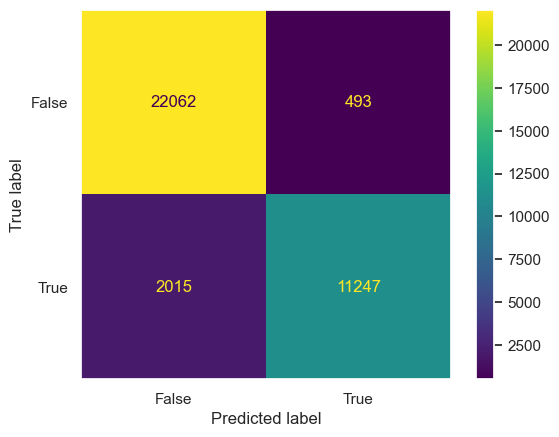

In [41]:
#Plot Random Forest Confusion Matrix
rfc_conf_display = ConfusionMatrixDisplay(confusion_matrix = rfc_conf, display_labels = [False, True])
rfc_conf_display.plot()
plt.grid(False)
plt.show()

## Conclusion

### Logistic regression model performance

In [42]:
mean_absolute_error(y_test, y_pred_lr)

0.18974230114191584

### Random forest regression model performance

In [43]:
mean_absolute_error(y_test, y_pred_rfc)

0.07002261495937684

The Random Forest Classifier is no doubt the better model. It has a much lower cross-validation mean absolute error and also exhibits less variability. 

### Future Improvments

Predicting cancellations is a real problem for the hotel industry! Having a good understanding of this problem and the features that closly relate with cancellations will be very useful to decrease the the possibility of your business being under/over prepared. Features with the most importance to predicting hotel booking cancellations are `lead_time`, `total_of_special_requests`, `required_car_parking_spaces` & `booking_changes`. Here Random Forest Algorithm has a high accuracy (93.09) to predict hotel booking cancellation as opposed to Logistic Regression (81.02)
